In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/AppliedAIinBiomedicine/final-assignment/training_set.zip -d /content/training_set

Archive:  /content/drive/MyDrive/AppliedAIinBiomedicine/final-assignment/training_set.zip
  inflating: /content/training_set/S001_128.mat  
  inflating: /content/training_set/S001_128_ann.mat  
  inflating: /content/training_set/S001_128_rpk.mat  
  inflating: /content/training_set/S002_128.mat  
  inflating: /content/training_set/S002_128_ann.mat  
 extracting: /content/training_set/S002_128_rpk.mat  
  inflating: /content/training_set/S003_128.mat  
  inflating: /content/training_set/S003_128_ann.mat  
  inflating: /content/training_set/S003_128_rpk.mat  
  inflating: /content/training_set/S004_128.mat  
  inflating: /content/training_set/S004_128_ann.mat  
 extracting: /content/training_set/S004_128_rpk.mat  
  inflating: /content/training_set/S005_128.mat  
  inflating: /content/training_set/S005_128_ann.mat  
  inflating: /content/training_set/S005_128_rpk.mat  
  inflating: /content/training_set/S006_128.mat  
  inflating: /content/training_set/S006_128_ann.mat  
  inflating: /co

In [3]:
input_dir = "/content/training_set"

In [4]:
import os

# list the data present in the dataset
os.listdir(input_dir)

['S061_128.mat',
 'S033_128_rpk.mat',
 'S047_128.mat',
 'S092_250_ann.mat',
 'S013_128.mat',
 'S002_128.mat',
 'S055_128.mat',
 'S086_250_rpk.mat',
 'S117_250.mat',
 'S004_128_rpk.mat',
 'S111_250.mat',
 'S083_250_rpk.mat',
 'S102_250.mat',
 'S028_128_rpk.mat',
 'S047_128_ann.mat',
 'S025_128_ann.mat',
 'S013_128_ann.mat',
 'S093_250_ann.mat',
 'S003_128_rpk.mat',
 'S060_128_rpk.mat',
 'S018_128_rpk.mat',
 'S041_128_rpk.mat',
 'S039_128.mat',
 'S106_250_rpk.mat',
 'S041_128_ann.mat',
 'S118_250_ann.mat',
 'S007_128_ann.mat',
 'S065_128_ann.mat',
 'S063_128.mat',
 'S116_250_rpk.mat',
 'S061_128_rpk.mat',
 'S006_128_ann.mat',
 'S044_128_ann.mat',
 'S007_128.mat',
 'S054_128_rpk.mat',
 'S097_250_ann.mat',
 'S096_250_rpk.mat',
 'S012_128_ann.mat',
 'S010_128.mat',
 'S091_250_rpk.mat',
 'S087_250_ann.mat',
 'S094_250.mat',
 'S088_250_ann.mat',
 'S114_250_ann.mat',
 'S009_128.mat',
 'S107_250_rpk.mat',
 'S107_250.mat',
 'S051_128_ann.mat',
 'S081_250_rpk.mat',
 'S005_128_ann.mat',
 'S031_128

Each data sample present:

*   sample.mat : 2-lead ECG signal of a patient of lenght n
*   sample_ann.mat : contains the annotations for each R peak

*   sample_rpk.mat : contains the R peak locations of the signal





# Data loading

In [150]:
# environment setup
from scipy.io import loadmat
import numpy as np, os, sys, joblib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import pandas as pd
import random

#Setting random seed for reproducibility
#Remember to use always SEED for the functions that requires it (like Scikit models)
SEED = 1234
np.random.seed(SEED)
pd.core.common._random_stat = SEED
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


In [6]:
# Utility function to load data

def load_data(ecg_file):
  ecg = loadmat(ecg_file)
  rpk_file = ecg_file.replace('.mat', '_rpk.mat')
  rpk = loadmat(rpk_file)
  ann_file = ecg_file.replace('.mat', '_ann.mat')
  ann = loadmat(ann_file)
  return ecg, rpk, ann

In [7]:
# Get the ecg file for each sample and create a list of all ecgs
ecg_files = []

for f in os.listdir(input_dir):
  g = os.path.join(input_dir, f)
  if ('ann' not in g) and ('rpk' not in g):
    ecg_files.append(g)
num_files = len(ecg_files)

# Create lists that will contains each data types (ecg, labels, rpeaks) an filenames (a list which contains the original filename for each sample)
filenames = list()
ecgs = list()
rpks = list()
anns = list()

for i in range(num_files):
  ecg, rpk, ann = load_data(ecg_files[i])
  print(
        "\rLoading file: {}/{}"
            .format(i+1, num_files),
        end=""
    )
  ecgs.append(ecg)
  rpks.append(rpk)
  anns.append(ann)
  filenames.append(ecg_files[i])


#ecg = np.asarray(loadmat(g)['ecg'], dtype=np.float64)
#rpk = np.asarray(loadmat(input_dir + "/S083_250_rpk.mat")['rpeaks'], dtype=np.float64)
#ann = np.asarray(loadmat(input_dir + "/S083_250_ann.mat")['labels'])

Loading file: 105/105

# Plot label distribution

In [8]:
classes_name = ['N', 'S', 'V']

In [9]:
# list which contains all labels of each beat
all_labels = []

for sample in anns:
  for beat in sample['labels']:
    all_labels.append(beat)

len(all_labels)

# create a counts of each labels
values, counts = np.unique(all_labels, return_counts=True)
values, counts

(array(['N', 'S', 'V'], dtype='<U1'), array([226932,   9609,   7795]))

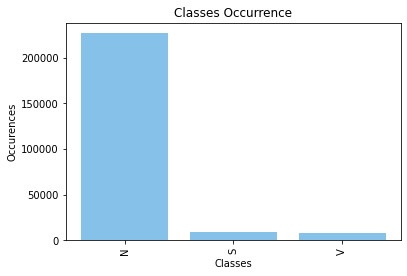

In [10]:
# Plot labels distribution (of all beats of all patients)
plt.bar(x=classes_name,height=counts, facecolor ='#85c1e9')
plt.title("Classes Occurrence", color = "black")
plt.tick_params(axis="both", colors = "black")
plt.xlabel("Classes", color = "black")
plt.ylabel("Occurences", color = "black")
plt.xticks(rotation=90)
plt.yticks
plt.show()

# Plot intervals boxplot

In [11]:
!pip install neurokit2

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [12]:
import neurokit2 as nk

In [13]:
# Utility: given the filename of a signal it returns the sampling frequency
def ecg_freq(filename):
  if '128' in filename:
    return 128
  else:
    return 250

[230389]
230400
{'ECG_R_Peaks': array([     5,    127,    249, ..., 230173, 230297, 230389], dtype=int32), 'sampling_rate': 128}


(-1.0, 3.0)

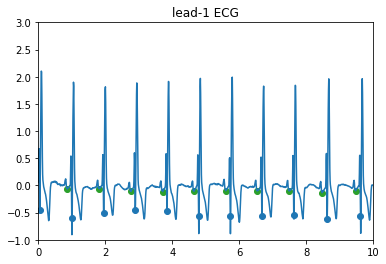

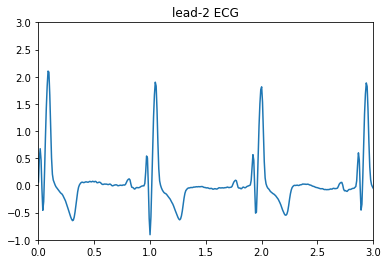

In [14]:
# PLOT SIGNAL EXAMPLE

# extract a sample ecg 
ecg_sample = np.asarray(ecgs[1]['ecg'], dtype=np.float64) 
sampling = ecg_freq(filenames[1]) 
ecg_sample_= np.arange(0, ecg_sample.shape[0]/sampling, 1/sampling)
 
#Extract peaks from traning set and their labels 
sample_rpeaks = rpks[1]['rpeaks'] 
rpeaks = {'ECG_R_Peaks': sample_rpeaks.flatten(), 'sampling_rate': sampling} 
print(sample_rpeaks[-1])
ecg_signal_1 = nk.ecg_clean(ecg_sample[:,1], sampling_rate=sampling, method='neurokit2') 
ecg_signal_2 = nk.ecg_clean(ecg_sample[:,1], sampling_rate=sampling, method='neurokit2') 

print(len(ecg_signal_1))
print(rpeaks)

_, waves_peak = nk.ecg_delineate(ecg_signal_1, rpeaks, sampling_rate=sampling, method="dwt")
_, waves_peak_2 = nk.ecg_delineate(ecg_signal_2, rpeaks, sampling_rate=sampling, method="dwt")
# Plot an example of signal (last ecg in previous loop)

#drop null values
for key in waves_peak.keys():
 waves_peak[key] = [w for w in waves_peak[key] if math.isnan(w) == False]

#create waves_peak in time domain in order to plot the value in the time domain
waves_peak_td = dict()
waves_peak_td['ECG_P_Peaks'] = [w  for w in waves_peak['ECG_P_Peaks'] ]
waves_peak_td['ECG_Q_Peaks'] = [w / sampling for w in waves_peak['ECG_Q_Peaks'] ]
waves_peak_td['ECG_T_Peaks'] = [w / sampling for w in waves_peak['ECG_T_Peaks'] ]
waves_peak_td['ECG_R_Onsets'] = [w / sampling for w in waves_peak['ECG_R_Onsets'] ]
waves_peak_td['ECG_P_Onsets'] = [w / sampling for w in waves_peak['ECG_P_Onsets'] ]
waves_peak_td['ECG_T_Offsets'] = [w / sampling for w in waves_peak['ECG_T_Offsets'] ]

plt.plot(ecg_sample_, ecg_signal_1)
plt.title("lead-1 ECG")
plt.scatter(rpeaks['ECG_R_Peaks'] / sampling, ecg_signal_1[rpeaks['ECG_R_Peaks']])
plt.scatter(waves_peak_td['ECG_P_Peaks'], ecg_signal_1[waves_peak['ECG_P_Peaks']])
plt.scatter(waves_peak_td['ECG_Q_Peaks'], ecg_signal_1[waves_peak['ECG_Q_Peaks']])
plt.scatter(waves_peak_td['ECG_T_Peaks'], ecg_signal_1[waves_peak['ECG_T_Peaks']])

plt.xlim(0,10)
plt.ylim(-1,3)

plt.figure()
plt.title("lead-2 ECG")
plt.plot(ecg_sample_, ecg_signal_2)
plt.xlim(0,3)
plt.ylim(-1,3)

In [49]:
# Exploration over some intervals of various single-beat signal

# lists that will contain PR and QR intervals
PR_N = list()
PR_S = list()
PR_V = list()

P_N = list()
P_S = list()
P_V = list()

QR_N = list()
QR_S = list()
QR_V = list()

# interval lists filling loop
for i in tqdm(range(len(ecgs))):
  # extract a sample ecg
  ecg_sample = np.asarray(ecgs[i]['ecg'], dtype=np.float64)
  sampling = ecg_freq(filenames[i])
  # Extract peaks from traning set and their labels
  sample_labels = anns[i]['labels']
  sample_rpeaks = rpks[i]['rpeaks']

  # clean ecg_sample
  ecg_signal = nk.ecg_clean(ecg_sample[:,0], sampling_rate=sampling, method='neurokit2')

  # Handling last beats (if last rpeak is >= to current ecg lenght, we remove it)
  if sample_rpeaks[-1] >= len(ecg_signal):
    sample_labels = sample_labels[:-1]
    sample_rpeaks = sample_rpeaks[:-1]

  #_,rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=sampling)
  # Building the dictionary with the rpeaks as the function of Neurokit wants
  rpeaks = {'ECG_R_Peaks': sample_rpeaks.flatten(), 'sampling_rate': sampling}
  
  _, waves_peak = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=sampling, method="dwt")
 
  #create waves_peak in time domain in order to plot the value in the time domain
  waves_peak_td = dict()

  #init the dictionary
  for k in waves_peak.keys():
    waves_peak_td[k] = list()

  for k in waves_peak.keys():
    for i in range(len(waves_peak[k])):
      if(math.isnan(waves_peak[k][i]) == False): #if is not nan, I divide the value for the frequency
        waves_peak_td[k].append(waves_peak[k][i] / sampling)
      else:
        waves_peak_td[k].append(waves_peak[k][i])  

  # add to the correct interval list the invterval of each beat of the current ecg sample

  for beat_index in range(len(sample_labels)):
    if sample_labels[beat_index] == 'N':
      try:
        P_N.append(ecg_signal[waves_peak['ECG_P_Peaks'][beat_index]])
      except:
        print("Not valid P_N wave; Adding nan")
        P_N.append(np.asarray([math.nan]))
      try:
        PR_N.append(sample_rpeaks[beat_index] / sampling - waves_peak_td['ECG_P_Onsets'][beat_index] )
      except:
        print("Not valid PR_N Interval; Adding nan")
        PR_N.append(np.asarray([math.nan]))
      try:  
        QR_N.append(waves_peak_td['ECG_T_Offsets'][beat_index] - sample_rpeaks[beat_index] / sampling)
      except:
        print("Not valid QR_N Interval; Adding nan")
        QR_N.append(np.asarray([math.nan]))
    elif sample_labels[beat_index] == 'S':
      try:
        P_S.append(ecg_signal[waves_peak['ECG_P_Peaks'][beat_index]])
      except:
        print("Not valid P_S wave; Adding nan")
        P_S.append(np.asarray([math.nan]))  
      try:
        PR_S.append(sample_rpeaks[beat_index] / sampling - waves_peak_td['ECG_P_Onsets'][beat_index] )
      except:
        print("Not valid PR_S interval; Adding nan")
        PR_S.append(np.asarray([math.nan]))
      try:  
        QR_S.append(waves_peak_td['ECG_T_Offsets'][beat_index] - sample_rpeaks[beat_index] / sampling)
      except:
        print("Not valid QR_S interval; Adding nan")
        QR_S.append(np.asarray([math.nan]))
    else:
      try:
        P_V.append(ecg_signal[waves_peak['ECG_P_Peaks'][beat_index]])
      except:
        print("Not valid P_V wave; Adding nan")
        P_V.append(np.asarray([math.nan]))  
      try:
        PR_V.append(sample_rpeaks[beat_index] / sampling - waves_peak_td['ECG_P_Onsets'][beat_index] )
      except:
        print("Not valid PR_V interval; Adding nan")
        PR_V.append(np.asarray([math.nan]))
      try: 
        QR_V.append(waves_peak_td['ECG_T_Offsets'][beat_index] - sample_rpeaks[beat_index] / sampling)
      except:
        print("Not valid QR_V interval; Adding nan")
        QR_V.append(np.asarray([math.nan]))

  2%|▏         | 2/105 [01:07<56:44, 33.06s/it]  

Not valid P_S wave; Adding nan
Not valid PR_S interval; Adding nan


  4%|▍         | 4/105 [02:20<59:15, 35.21s/it]


KeyboardInterrupt: ignored

In [50]:
print(len(PR_N))
print(len(PR_V))
print(len(PR_S))

7136
127
655


In [51]:
PR_S

[array([0.203125]),
 array([0.25]),
 array([0.375]),
 array([0.4140625]),
 array([0.140625]),
 array([0.40625]),
 array([0.390625]),
 array([0.3828125]),
 array([-0.6640625]),
 array([-0.4921875]),
 array([-0.5234375]),
 array([-1.21875]),
 array([-0.40625]),
 array([-0.2109375]),
 array([-0.8671875]),
 array([nan]),
 array([0.28125]),
 array([0.2421875]),
 array([0.203125]),
 array([0.265625]),
 array([0.25]),
 array([0.2265625]),
 array([0.2578125]),
 array([0.2578125]),
 array([0.2890625]),
 array([0.3359375]),
 array([0.2890625]),
 array([0.2734375]),
 array([0.3359375]),
 array([0.265625]),
 array([0.1875]),
 array([0.1484375]),
 array([0.1875]),
 array([0.171875]),
 array([0.1953125]),
 array([0.1875]),
 array([0.1796875]),
 array([0.1796875]),
 array([0.1875]),
 array([0.1796875]),
 array([0.1796875]),
 array([0.171875]),
 array([0.171875]),
 array([0.171875]),
 array([0.1796875]),
 array([0.171875]),
 array([0.1484375]),
 array([0.1796875]),
 array([0.1484375]),
 array([0.17187

In [52]:
#Flatten the structure of the array
PR_N = [item for sublist in PR_N for item in sublist]
PR_V = [item for sublist in PR_V for item in sublist]
PR_S = [item for sublist in PR_S for item in sublist]

In [53]:
#Flatten the structure of the array
QR_N = [item for sublist in QR_N for item in sublist]
QR_V = [item for sublist in QR_V for item in sublist]
QR_S = [item for sublist in QR_S for item in sublist]

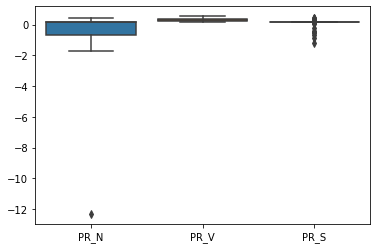

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

boxplot_dictionary_PR = dict( PR_N = PR_N, PR_V = PR_V, PR_S = PR_S )
df_PR = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in boxplot_dictionary_PR.items() ]))

sns.boxplot(data=df_PR)


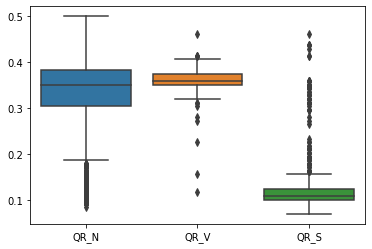

In [55]:
boxplot_dictionary_QR = dict( QR_N = QR_N, QR_V = QR_V, QR_S = QR_S )
df_QR = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in boxplot_dictionary_QR.items() ]))
sns.boxplot(data = df_QR)

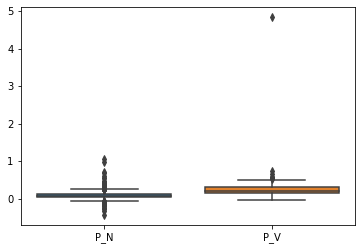

In [56]:
boxplot_dictionary_P = dict( P_N = P_N, P_V = P_V, P_S = P_S )
df_P = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in boxplot_dictionary_P.items() ]))
sns.boxplot(data = df_P)

# Single heartbeat extraction

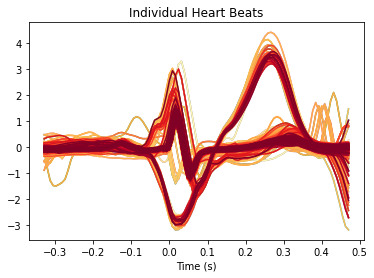

In [57]:
# extract a sample ecg 
ecg_sample = np.asarray(ecgs[0]['ecg'], dtype=np.float64) 
sampling = ecg_freq(filenames[0]) 
 
#Extract peaks from traning set and their labels 
sample_rpeaks = rpks[0]['rpeaks'] 
rpeaks = {'ECG_R_Peaks': sample_rpeaks.flatten(), 'sampling_rate': sampling} 
 
ecg_signal = nk.ecg_clean(ecg_sample[:,0], sampling_rate=sampling, method='neurokit2') 
 
# extract heartbeats of current ecg 
ecg_heartbeats = nk.ecg_segment(ecg_cleaned=ecg_signal, rpeaks=rpeaks['ECG_R_Peaks'], sampling_rate=sampling, show=True)

In [ ]:
# Try to extract each single heartbeat

# list of list that contains all heartbeats divided by patient
patient_heartbeats = []

for i in tqdm(range(len(ecgs))):
  # extract a sample ecg
  ecg_sample = np.asarray(ecgs[i]['ecg'], dtype=np.float64)
  sampling = ecg_freq(filenames[i])
  #ecg_sample_= np.arange(0, ecg_sample.shape[0]/sampling, 1/sampling)
  # clean ecg_sample
  ecg_signal = nk.ecg_clean(ecg_sample[:,0], sampling_rate=sampling, method='neurokit2')
  #Extract peaks from traning set and their labels
  sample_rpeaks = rpks[i]['rpeaks'] 
  # Handling last beats (if last rpeak is >= to current ecg lenght, we remove it)
  if sample_rpeaks[-1] >= len(ecg_signal):
    sample_labels = sample_labels[:-1]
    sample_rpeaks = sample_rpeaks[:-1]
 
  rpeaks = {'ECG_R_Peaks': sample_rpeaks.flatten(), 'sampling_rate': sampling}

  # extract heartbeats of current ecg
  ecg_heartbeats = nk.ecg_segment(ecg_cleaned=ecg_signal, rpeaks=rpeaks['ECG_R_Peaks'], sampling_rate=sampling)
  patient_heartbeats.append(ecg_heartbeats)

  

## HRV Features Extraction

This part is related to the extraction of the HRV features like RR interval,dRR_n = RR_{n+1} - RR_{n-1} (for each beat that is not first and last). 
Moreover, we extract a {2,5} minutes centered on an R-peak windows and from this windows we extract the mean and standard deviation of both RR and dRR and root mean square of successive differences (RMSSD) (TODO).

*Example on a single signal*

In [145]:
def get_RRs_in_window(rr_intervals, drr_intervals, sample_rpeaks_s, index, window_size_in_minutes = 2):
  #find a windows of dimension 2 minutes around the current R-peak
  cumulative_time = 0
  #window part before the index
  first_index = 0
  last_index = math.inf 
  for i in range(index, 0, -1):
    cumulative_time = cumulative_time + abs(sample_rpeaks_s[i] - sample_rpeaks_s[index])
    if(cumulative_time >= window_size_in_minutes * 60 / 2 and first_index == 0): #stop the extension of the window
      first_index = i

  cumulative_time = 0
  #window part after the index
  for j in range(index, len(sample_rpeaks_s), +1):
     cumulative_time = cumulative_time + abs(sample_rpeaks_s[j] - sample_rpeaks_s[index])
     if(cumulative_time >= window_size_in_minutes * 60 / 2 and last_index == math.inf): #stop the extension of the window
      last_index = j

  return rr_intervals[first_index:last_index], drr_intervals[first_index:last_index]

length of the current sample is 30.0 minutes
first peak 2 min at 66
last peak 2 miin at 1837


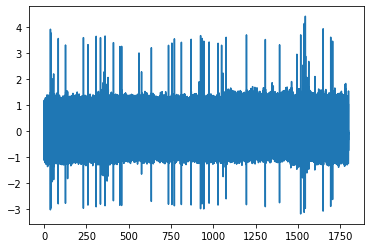

In [146]:
# extract a sample ecg 
ecg_sample = np.asarray(ecgs[0]['ecg'], dtype=np.float64) 
sampling = ecg_freq(filenames[0]) 
ecg_sample_= np.arange(0, ecg_sample.shape[0]/sampling, 1/sampling)
 
#Extract peaks from traning set and their labels 
sample_rpeaks = rpks[0]['rpeaks'] 
rpeaks = {'ECG_R_Peaks': sample_rpeaks.flatten(), 'sampling_rate': sampling} 
 
ecg_signal = nk.ecg_clean(ecg_sample[:,0], sampling_rate=sampling, method='neurokit2') 
 
plt.plot(ecg_sample_, ecg_signal)

#Calculation of RR intervals
#conversion in seconds of R peaks
sample_rpeaks_s = [sample / sampling for sample in sample_rpeaks.flatten()]
rr_intervals = []

for i in range(len(sample_rpeaks_s) - 1):
  rr_intervals.append(sample_rpeaks_s[i+1] - sample_rpeaks_s[i])
#adding nan value for last peak
rr_intervals.append(math.nan)

#calculating dRR
drr_intervals = []

for i in range(len(rr_intervals)):
  if(i == 0 or i == len(rr_intervals) -1): #we need to skip first iteration and last iteration since we do not have the values
    drr_intervals.append(math.nan)
  else:  
    drr_intervals.append(rr_intervals[i+1] - rr_intervals[i-1])

#Extraction of a window of n minutes (n/2 minutes before and n/2 minutes after) centered on current RR
print("length of the current sample is",len(ecg_signal)/sampling/60, "minutes")
#Boundaries of the windows namely first index and last index are
first_peak_of_window_2_min = -1
last_peak_of_window_2_min = math.inf

first_peak_of_window_5_min = -1
last_peak_of_window_5_min = math.inf

for i in range(len(sample_rpeaks_s)):
  if(sample_rpeaks_s[i] >= 1.0*60 and first_peak_of_window_2_min == -1):
    first_peak_of_window_2_min = i

for i in range(len(sample_rpeaks_s)):
  if(sample_rpeaks_s[i] >= 2.5*60 and first_peak_of_window_5_min == -1):
    first_peak_of_window_5_min = i

#starting from the last index in order to get the last index that satisfy the condition
for i in range(len(sample_rpeaks_s) - 1, 0, -1):
  if(sample_rpeaks_s[i] < 29.0 * 60  and last_peak_of_window_2_min == math.inf):
    last_peak_of_window_2_min = i 

for i in range(len(sample_rpeaks_s) - 1, 0, -1):
  if(sample_rpeaks_s[i] < 27.5 * 60  and last_peak_of_window_5_min == math.inf):
    last_peak_of_window_5_min = i 

print("first peak 2 min at", first_peak_of_window_2_min)
print("last peak 2 miin at", last_peak_of_window_2_min)

#fill the first and the last position of the values related to windows measures with nan
rr_mean_2_min = []
rr_std_2_min = []
rr_mean_5_min = []
rr_std_5_min = []

drr_mean_2_min = []
drr_std_2_min = []
drr_mean_5_min = []
drr_std_5_min = []
#TODO: rmssd
for i in range(len(sample_rpeaks_s)):
  if(i <= first_peak_of_window_2_min or i >= last_peak_of_window_2_min):
    rr_mean_2_min.append(math.nan)
    rr_std_2_min.append(math.nan)
    drr_mean_2_min.append(math.nan)
    drr_std_2_min.append(math.nan)
  else:
    rr_in_window, drr_in_window = get_RRs_in_window(rr_intervals, drr_intervals, sample_rpeaks_s, i)
    rr_mean_2_min.append(np.nanmean(rr_in_window))
    rr_std_2_min.append(np.nanstd(rr_in_window))
    drr_mean_2_min.append(np.nanmean(drr_in_window))
    drr_std_2_min.append(np.nanstd(drr_in_window))

for i in range(len(sample_rpeaks_s)):
  if(i <= first_peak_of_window_5_min or i >= last_peak_of_window_5_min):
    rr_mean_5_min.append(math.nan)
    rr_std_5_min.append(math.nan)
    drr_mean_5_min.append(math.nan)
    drr_std_5_min.append(math.nan)
  else:
    rr_in_window, drr_in_window = get_RRs_in_window(rr_intervals, drr_intervals, sample_rpeaks_s, i, window_size_in_minutes=5)
    rr_mean_5_min.append(np.nanmean(rr_in_window))
    rr_std_5_min.append(np.nanstd(rr_in_window))
    drr_mean_5_min.append(np.nanmean(drr_in_window))
    drr_std_5_min.append(np.nanstd(drr_in_window))

In [147]:
hpv_features = dict( rr_intervals = rr_intervals, drr_intervals = drr_intervals, rr_mean_2_min_window = rr_mean_2_min,
                    rr_std_2_min_window = rr_std_2_min, drr_mean_2_min_window = drr_mean_2_min, drr_std_2_min_window = drr_std_2_min,
                    rr_std_5_min_window = rr_std_5_min, drr_mean_5_min_window = drr_mean_5_min, drr_std_5_min_window = drr_std_5_min)
hpv_features = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in hpv_features.items() ]))
hpv_features.describe()

,rr_intervals,drr_intervals,rr_mean_2_min_window,rr_std_2_min_window,drr_mean_2_min_window,drr_std_2_min_window,rr_std_5_min_window,drr_mean_5_min_window,drr_std_5_min_window
count,1902.000000,1900.000000,1770.000000,1770.000000,1770.000000,1770.000000,1580.000000,1580.000000,1580.000000
mean,0.945781,0.000037,0.948012,0.085394,-0.000070,0.106992,0.093839,-0.000051,0.114940
std,0.117050,0.138345,0.051809,0.062026,0.008989,0.085491,0.053600,0.006207,0.073379
min,0.367188,-0.757812,0.778438,0.006738,-0.051291,0.005726,0.010112,-0.034722,0.011021
25%,0.914062,-0.015625,0.927028,0.028133,-0.004261,0.025570,0.040023,-0.002821,0.033838
50%,0.953125,0.000000,0.954190,0.067415,0.000000,0.087860,0.099879,-0.000217,0.133730
75%,0.992188,0.023438,0.983665,0.129429,0.003906,0.181723,0.120031,0.003094,0.160234
max,1.390625,0.585938,1.075149,0.262672,0.046520,0.309328,0.235146,0.031250,0.307265


### Extraction of the HPV features on the whole Dataset

In [148]:
# list of list that contains all hpv features divided by patient
patient_hpv = []

for i in tqdm(range(len(ecgs))):
  # extract a sample ecg
  sampling = ecg_freq(filenames[i])
  #Extract peaks from traning set and their labels
  sample_rpeaks = rpks[i]['rpeaks']
  #Calculation of RR intervals
  #conversion in seconds of R peaks
  sample_rpeaks_s = [sample / sampling for sample in sample_rpeaks.flatten()]
  rr_intervals = []

  for i in range(len(sample_rpeaks_s) - 1):
    rr_intervals.append(sample_rpeaks_s[i+1] - sample_rpeaks_s[i])
  #adding nan value for last peak
  rr_intervals.append(math.nan)

  #calculating dRR
  drr_intervals = []

  for i in range(len(rr_intervals)):
    if(i == 0 or i == len(rr_intervals) -1): #we need to skip first iteration and last iteration since we do not have the values
      drr_intervals.append(math.nan)
    else:  
      drr_intervals.append(rr_intervals[i+1] - rr_intervals[i-1])

  #Extraction of a window of n minutes (n/2 minutes before and n/2 minutes after) centered on current RR
  #Boundaries of the windows namely first index and last index are
  first_peak_of_window_2_min = -1
  last_peak_of_window_2_min = math.inf

  first_peak_of_window_5_min = -1
  last_peak_of_window_5_min = math.inf

  for i in range(len(sample_rpeaks_s)):
    if(sample_rpeaks_s[i] >= 1.0*60 and first_peak_of_window_2_min == -1):
      first_peak_of_window_2_min = i

  for i in range(len(sample_rpeaks_s)):
    if(sample_rpeaks_s[i] >= 2.5*60 and first_peak_of_window_5_min == -1):
      first_peak_of_window_5_min = i

  #starting from the last index in order to get the last index that satisfy the condition
  for i in range(len(sample_rpeaks_s) - 1, 0, -1):
    if(sample_rpeaks_s[i] < 29.0 * 60  and last_peak_of_window_2_min == math.inf):
      last_peak_of_window_2_min = i 

  for i in range(len(sample_rpeaks_s) - 1, 0, -1):
    if(sample_rpeaks_s[i] < 27.5 * 60  and last_peak_of_window_5_min == math.inf):
      last_peak_of_window_5_min = i 

  #fill the first and the last position of the values related to windows measures with nan
  rr_mean_2_min = []
  rr_std_2_min = []
  rr_mean_5_min = []
  rr_std_5_min = []

  drr_mean_2_min = []
  drr_std_2_min = []
  drr_mean_5_min = []
  drr_std_5_min = []
  #TODO: rmssd
  for i in range(len(sample_rpeaks_s)):
    if(i <= first_peak_of_window_2_min or i >= last_peak_of_window_2_min): #filling with nan the values that are not available
      rr_mean_2_min.append(math.nan)
      rr_std_2_min.append(math.nan)
      drr_mean_2_min.append(math.nan)
      drr_std_2_min.append(math.nan)
    else:
      rr_in_window, drr_in_window = get_RRs_in_window(rr_intervals, drr_intervals, sample_rpeaks_s, i)
      rr_mean_2_min.append(np.nanmean(rr_in_window))
      rr_std_2_min.append(np.nanstd(rr_in_window))
      drr_mean_2_min.append(np.nanmean(drr_in_window))
      drr_std_2_min.append(np.nanstd(drr_in_window))

  for i in range(len(sample_rpeaks_s)):
    if(i <= first_peak_of_window_5_min or i >= last_peak_of_window_5_min): #filling with nan the values that are not available
      rr_mean_5_min.append(math.nan)
      rr_std_5_min.append(math.nan)
      drr_mean_5_min.append(math.nan)
      drr_std_5_min.append(math.nan)
    else:
      rr_in_window, drr_in_window = get_RRs_in_window(rr_intervals, drr_intervals, sample_rpeaks_s, i, window_size_in_minutes=5)
      rr_mean_5_min.append(np.nanmean(rr_in_window))
      rr_std_5_min.append(np.nanstd(rr_in_window))
      drr_mean_5_min.append(np.nanmean(drr_in_window))
      drr_std_5_min.append(np.nanstd(drr_in_window))

  hpv_features = dict( rr_intervals = rr_intervals, drr_intervals = drr_intervals, rr_mean_2_min_window = rr_mean_2_min,
                    rr_std_2_min_window = rr_std_2_min, drr_mean_2_min_window = drr_mean_2_min, drr_std_2_min_window = drr_std_2_min,
                    rr_std_5_min_window = rr_std_5_min, drr_mean_5_min_window = drr_mean_5_min, drr_std_5_min_window = drr_std_5_min)
  #add the dictionary of the features extracted to the list of the patient
  patient_hpv.append(hpv_features)
 

 60%|██████    | 63/105 [10:47<07:11, 10.28s/it]


KeyboardInterrupt: ignored